This notebook will have an analysis that studies the contribution of individual neuromodulators to the encoding of reward during this task. The data is from the Nucleus Acumbens. Here we use three labels instead of two: rewarded, unrewarded and no choice (to signify the trials where the animal didn't make a choice).

In [2]:

import numpy as np
import itertools
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import solve_ivp
import cebra.data
import torch
import cebra.integrations
import cebra.datasets
from cebra import CEBRA
import torch
import pickle
import utils

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc



from matplotlib.collections import LineCollection
import pandas as pd

Iterate this for the 4 combinations of 3 NMs

- separate the data into these 4 combinations and use this as input
- The different datasets: 
    - without DA, NE, 5HT, AcH

## Load and format the Neuromodulator (NM) data and behavioural labels

In [3]:
# load the dataframe
df_trials_ses = pickle.load(open('/Users/brian.gitahi/Desktop/AIND/CEBRA/Git/CEBRA-Demo/data/CO data/df.pkl', "rb"))

In [4]:
# load the dictionary containing the traces
traces = pickle.load(open('/Users/brian.gitahi/Desktop/AIND/CEBRA/Git/CEBRA-Demo/data/CO data/traces.pkl', "rb"))

In [5]:
# load the trace times
trace_times = np.load('/Users/brian.gitahi/Desktop/AIND/CEBRA/Git/CEBRA-Demo/data/CO data/Trace times.npy', allow_pickle=True)

In [6]:
# Combine the traces for all NMs into one 2D array
all_nms = np.array([traces[trace] for trace in traces.keys()])
all_nms = np.transpose(all_nms)

In [7]:
all_nms.shape

(218572, 4)

In [29]:
df_trials_ses

,bit_code,ses_idx,rpe,left_action_value,right_action_value,licks L,licks R,Lick L (raw),Lick R (raw),trial,...,reward_time,onset,NM,NM_name,region,last_value_NM,overlap_index,NM_no_overlap,bins_mids,bins_mids_no_overlap
0,00110001111001010011,632106_2022-08-23,1.000000,0.000000e+00,0.327773,26.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,...,92.362000,"[-1.0, -0.9500000000000028, -0.900000000000005...","[-0.006876904734641623, -0.007146692736817482,...",DA,NAc,NaN,0,"[-0.006876904734641623, -0.007146692736817482,...","[-0.9750000000000014, -0.9250000000000043, -0....","[91.05000152587891, 91.1000015258789, 91.15000..."
1,10101101011111010011,632106_2022-08-23,-0.327773,0.000000e+00,0.222074,10.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,...,NaN,"[-1.0, -0.9500000000000028, -0.900000000000005...","[0.09396514270492158, 0.09166120346690362, 0.0...",DA,NAc,0.074671,18,"[0.07467145399912882, 0.07390178461889173, 0.0...","[-0.9750000000000014, -0.9250000000000043, -0....","[100.83500366210933, 100.88500366210931, 100.9..."
2,10110000011000010100,632106_2022-08-23,-0.222074,0.000000e+00,0.150461,2.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2,...,NaN,"[-1.0, -0.9500000000000028, -0.900000000000005...","[0.03888178725609381, 0.03576014157991385, 0.0...",DA,NAc,0.111702,18,"[0.1117021239456095, 0.1111829908404548, 0.114...","[-0.9750000000000014, -0.9250000000000043, -0....","[108.38499908447261, 108.4349990844726, 108.48..."
3,10111100010010100001,632106_2022-08-23,-0.150461,0.000000e+00,0.101941,2.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3,...,NaN,"[-1.0, -0.9500000000000028, -0.900000000000005...","[0.04022817060438801, 0.04426318323498179, 0.0...",DA,NAc,0.039222,19,"[0.039221979243197015, 0.04083176200307425, 0....","[-0.9750000000000014, -0.9250000000000043, -0....","[113.19799957275384, 113.24799957275386, 113.2..."
4,01101111100010011111,632106_2022-08-23,-0.101941,0.000000e+00,0.069068,1.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4,...,NaN,"[-1.0, -0.9500000000000028, -0.900000000000005...","[0.027914873653080343, 0.028333289056160112, 0...",DA,NAc,0.023959,19,"[0.023959280634978056, 0.02501534419509218, 0....","[-0.9750000000000014, -0.9250000000000043, -0....","[117.01500091552728, 117.06500091552729, 117.1..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1760,00011101000011111011,632106_2022-08-23,-0.824473,1.198410e-05,0.558602,1.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1754,...,NaN,"[-1.0, -0.9500000000007276, -0.900000000001455...","[-0.0012799915180941783, -0.000190254206188288...",ACh,NAc,0.001646,19,"[0.0016461378021336635, -0.0003314239969927528...","[-0.9750000000003638, -0.9250000000010914, -0....","[10949.811914062486, 10949.861914062485, 10949..."
1761,00000100001000111000,632106_2022-08-23,0.441398,5.779060e-06,0.703280,3.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1755,...,10954.419922,"[-1.0, -0.9500000000007276, -0.900000000001455...","[0.002407675576329689, 0.004578818551264469, 0...",ACh,NAc,0.000260,18,"[0.00026042376397175855, 0.0025022589975745445...","[-0.9750000000003638, -0.9250000000010914, -0....","[10954.139843749987, 10954.189843749986, 10954..."
1762,01011100011001010000,632106_2022-08-23,0.296720,2.786810e-06,0.800537,2.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1756,...,10960.533203,"[-1.0, -0.9500000000007276, -0.900000000001455...","[0.004071718630667636, 0.0019159427498036115, ...",ACh,NAc,0.005961,19,"[0.00596118894201

In [8]:
# change it to an array of floats (previously it was an array of object datatype)
all_nms_new = all_nms.astype(np.float64)
all_nms_new.shape

(218572, 4)

In [9]:
n_trials = 1765

In [10]:
# get the choice time 
choice_times = df_trials_ses['choice_time'][0:n_trials].to_numpy()

In [11]:
np.unique(np.isnan(choice_times),return_counts=True)[1][0]

1717

In [28]:
np.nanmax(np.diff(choice_times))

328.603515625

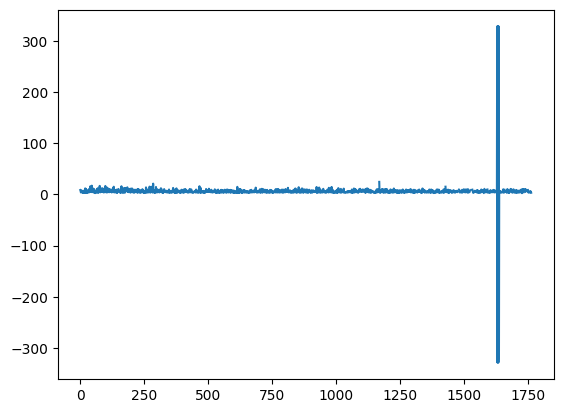

In [24]:
plt.plot(np.diff(choice_times))

In [13]:
np.unique(np.isnan(choice_times), return_counts=True)

(array([False,  True]), array([1717,   48]))

In [11]:
# Make a function to format the NM data into a 1s window around the choice

def format_data(neural_data, df = df_trials_ses, trace_times_ = trace_times, choice_times_ = choice_times, window_size=20, n_trials=1765):

    # define the number of trials where the mouse made a choice
    n_choice_trials = np.unique(np.isnan(choice_times_),return_counts=True)[1][0]

    # list to hold all the 1s windows
    n_data_window = []

    # new trial label
    trial_labels = []

    # loop over all trials
    for i in range(0,n_trials):

        # if the animal didn't make choice label that trial as no choice 
        if np.isnan(choice_times_[i]):
            continue

        # find the index of the closest time to the choice time in the trace_times array 
        idx = np.abs(trace_times_ - choice_times_[i]).argmin()

        # take the previous 10 and the next 10 values of the NM data at these indices - 1s window
        n_data_window.append(neural_data[idx-10:idx+10])

        # label the timepoints as rewarded or unrewarded
        if df['reward'].iloc[i]:
            # new trial label
            trial_labels.append(1)

        elif df['reward'].iloc[i]==False:
            # new trial label
            trial_labels.append(0)


    # stack the nm data for each trial
    nms_HD = np.stack(n_data_window).reshape((n_choice_trials,-1))
    # format it into a tensor
    nms_HD = torch.from_numpy(nms_HD.astype(np.float64))
    print("neural tensor shape: ", nms_HD.shape)

    # convert trial labels into an array
    trial_labels = np.array(trial_labels)
    print("labels shape: ",trial_labels.shape)

    return nms_HD, trial_labels


In [12]:
all_nms_HD, trial_labels_ = format_data(all_nms)

neural tensor shape:  torch.Size([1717, 80])
labels shape:  (1717,)


## Build and train the model then compute embeddings

In [13]:
max_iterations = 2000

In [14]:
trial_labels_.shape

(1717,)

In [18]:
def build_train_compute(neural_data, b_label):


    # build time and behaviour models
    cebra_time_model = CEBRA(model_architecture='offset10-model-mse',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1,
                        output_dimension=3,
                        max_iterations=max_iterations,
                        distance='euclidean',
                        conditional='time',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10) 

    cebra_behaviour_model = CEBRA(model_architecture='offset10-model-mse',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1,
                        output_dimension=3,
                        max_iterations=max_iterations,
                        distance='euclidean',
                        conditional='time_delta',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10)

    # train them both
    cebra_time_model.fit(neural_data)
    cebra_behaviour_model.fit(neural_data, b_label)

    # compute the embeddings
    time_embedding = cebra_time_model.transform(neural_data)
    behaviour_embedding = cebra_behaviour_model.transform(neural_data)

    # return the embeddings 

    return time_embedding, behaviour_embedding

In [19]:
all_nms_HD.shape

torch.Size([1717, 80])

In [20]:
t_embed_4, b_embed_4 = build_train_compute(all_nms_HD,trial_labels_)

pos:  0.9913 neg:  2.7242 total:  3.7155 temperature:  1.0000: 100%|██████████| 2000/2000 [00:52<00:00, 38.41it/s]
pos:  0.3796 neg:  5.5441 total:  5.9237 temperature:  1.0000:  20%|██        | 407/2000 [00:10<00:44, 36.10it/s]

## Then visualize the embeddings

In [ ]:
# divide the labels into rewarded and unrewarded
def define_label_classes(trial_labels = trial_labels_):

    rewarded = trial_labels==1
    unrewarded = trial_labels==0

    rewarded = rewarded.flatten()
    unrewarded = unrewarded.flatten()

    return rewarded, unrewarded

In [50]:
rewarded, unrewarded = define_label_classes()

In [54]:
# view the embeddings

def view(time_embedding, behaviour_embedding, labels, label_classes, title ="Different Angles", size=0.8):
 
    # create a figure and make the plots
    fig = plt.figure(figsize=(14,8))
    gs = gridspec.GridSpec(1, 2, figure=fig)


    ax81 = fig.add_subplot(gs[0,0], projection='3d')
    ax82 = fig.add_subplot(gs[0,1], projection='3d')
    # ax81.axis('off')
    # ax82.axis('off')


    # colour maps
    colours = ['cool', 'plasma', 'spring']

    # plot the time embedding 
    cebra.plot_embedding(embedding=time_embedding[label_classes[0],:], embedding_labels=labels[label_classes[0]],ax=ax81, markersize=2, title='Time embedding', cmap=colours[0])
    cebra.plot_embedding(embedding=time_embedding[label_classes[1],:], embedding_labels=labels[label_classes[1]],ax=ax81, markersize=2, title='Time embedding', cmap=colours[1])


    # plot the behaviour embedding 
    cebra.plot_embedding(embedding=behaviour_embedding[label_classes[0],:], embedding_labels=labels[label_classes[0]],ax=ax82, markersize=2, title='Behaviour embedding', cmap=colours[0],)
    cebra.plot_embedding(embedding=behaviour_embedding[label_classes[1],:], embedding_labels=labels[label_classes[1]],ax=ax82,markersize=2, title='Behaviour embedding',  cmap=colours[1])

    gs.tight_layout(figure=fig)

    print("prepaing figure at multiple angles")

    # then view it at multiple angles
    utils.view_embedding(time_embedding, behaviour_embedding,s=size,label=labels,label_class=label_classes, titles=['time embedding','behaviour_embedding'], main_title=title)

prepaing figure at multiple angles


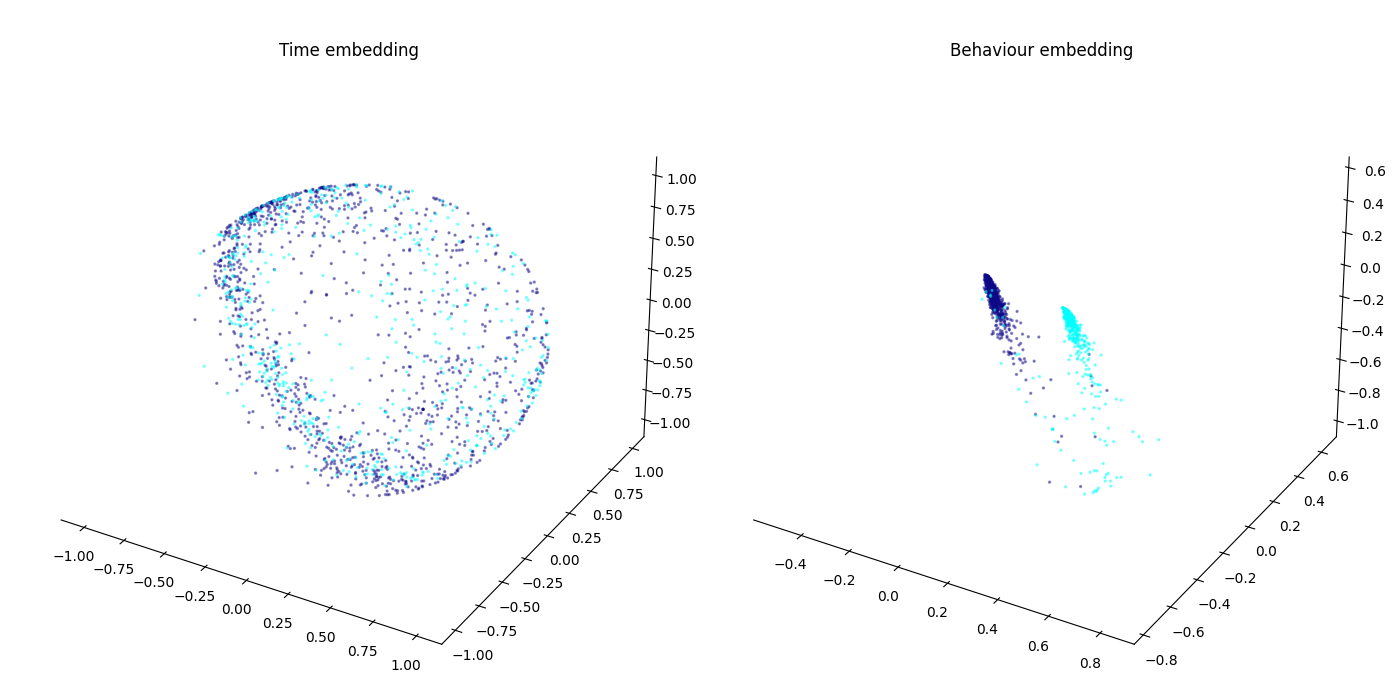

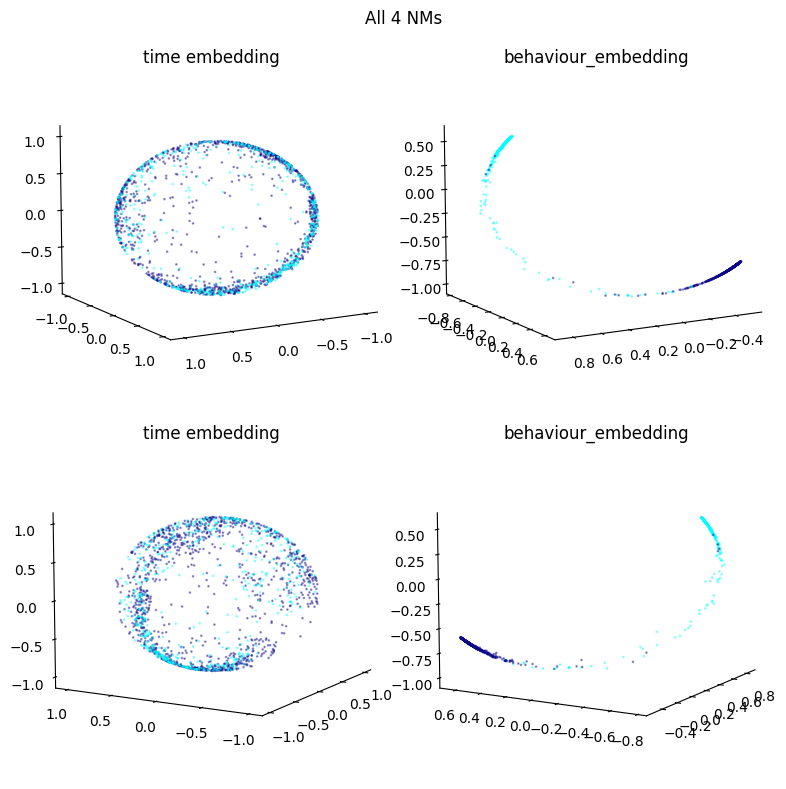

In [55]:
view(t_embed_4, b_embed_4, trial_labels_,label_classes=[rewarded,unrewarded], title="All 4 NMs")

## Analysis of different combinations of Neuromodulators

In [21]:
traces.keys()

dict_keys(['DA NAc', 'NE NAc', '5HT NAc', 'ACh NAc'])

In [62]:
# format the arrays
def create_datasets(traces_=traces):

    # create a list to hold the different combinations of NM data
    datasets = []

    # iterate through the keys in the dictionary holding the NM data
    for key in traces_:

        # at each iteration make an array of NM data and exclude the current NM from the array
        array = np.array([traces_[trace] for trace in traces_.keys() if trace !=key ])

        # format the array 
        f_array = np.transpose(array)
        f_array = f_array.astype(np.float64)
        print("shape of formatted array:", f_array.shape)
        datasets.append(f_array)


    return datasets

In [63]:
datasets = create_datasets()

shape of formatted array: (218572, 3)
shape of formatted array: (218572, 3)
shape of formatted array: (218572, 3)
shape of formatted array: (218572, 3)


In [64]:
# for each NM combination
def nm_analysis(data, missing_nm="" ):

    # format the data into 1s window around the choice and create the labels
    nms_HD, t_labels = format_data(neural_data=data)

    # Build and train the model then compute embeddings
    t_embed, b_embed = build_train_compute(nms_HD, t_labels)

    # define the label classes
    rewarded, unrewarded = define_label_classes(t_labels)

    # view the embeddings
    #view(t_embed, b_embed, t_labels,label_classes=[rewarded, unrewarded],title=missing_nm )

    return t_embed, b_embed



### No DA

neural tensor shape:  torch.Size([1717, 60])
labels shape:  (1717,)


pos:  1.0318 neg:  3.0121 total:  4.0439 temperature:  1.0000: 100%|██████████| 2000/2000 [00:47<00:00, 42.03it/s]
pos:  0.3007 neg:  5.5023 total:  5.8030 temperature:  1.0000: 100%|██████████| 2000/2000 [00:49<00:00, 40.17it/s]


prepaing figure at multiple angles


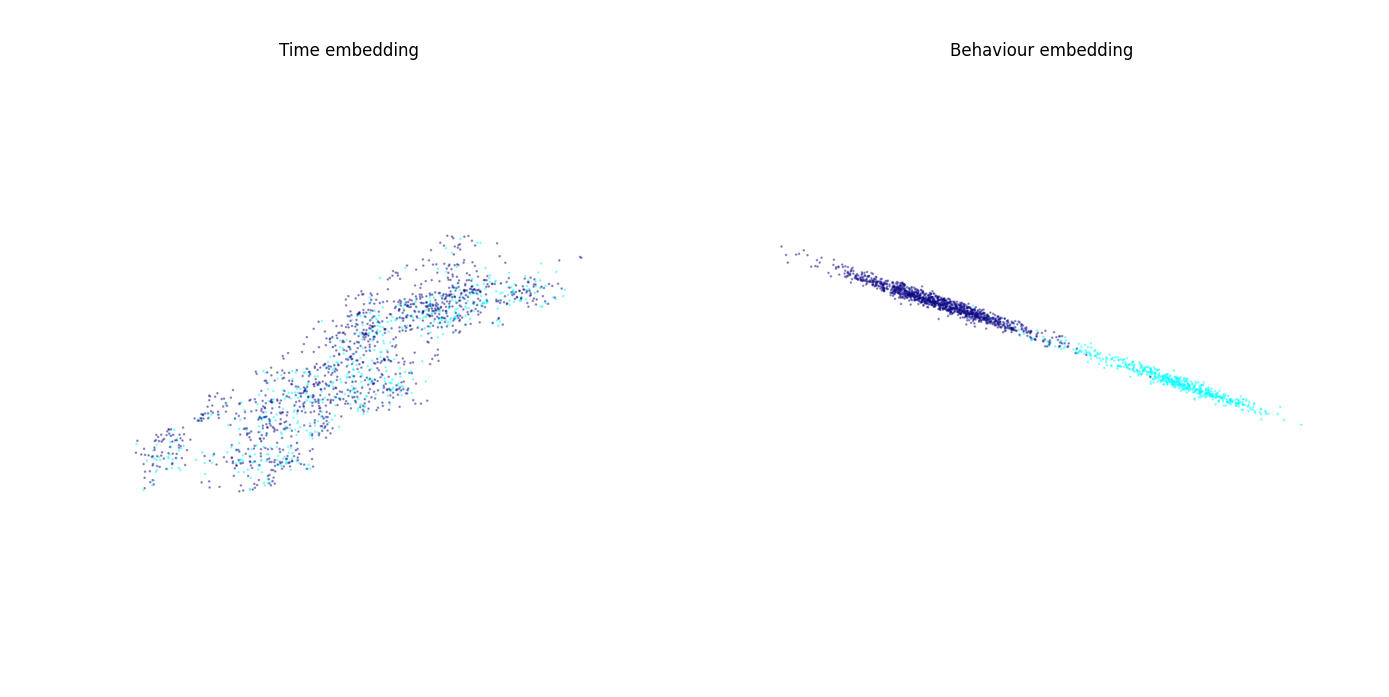

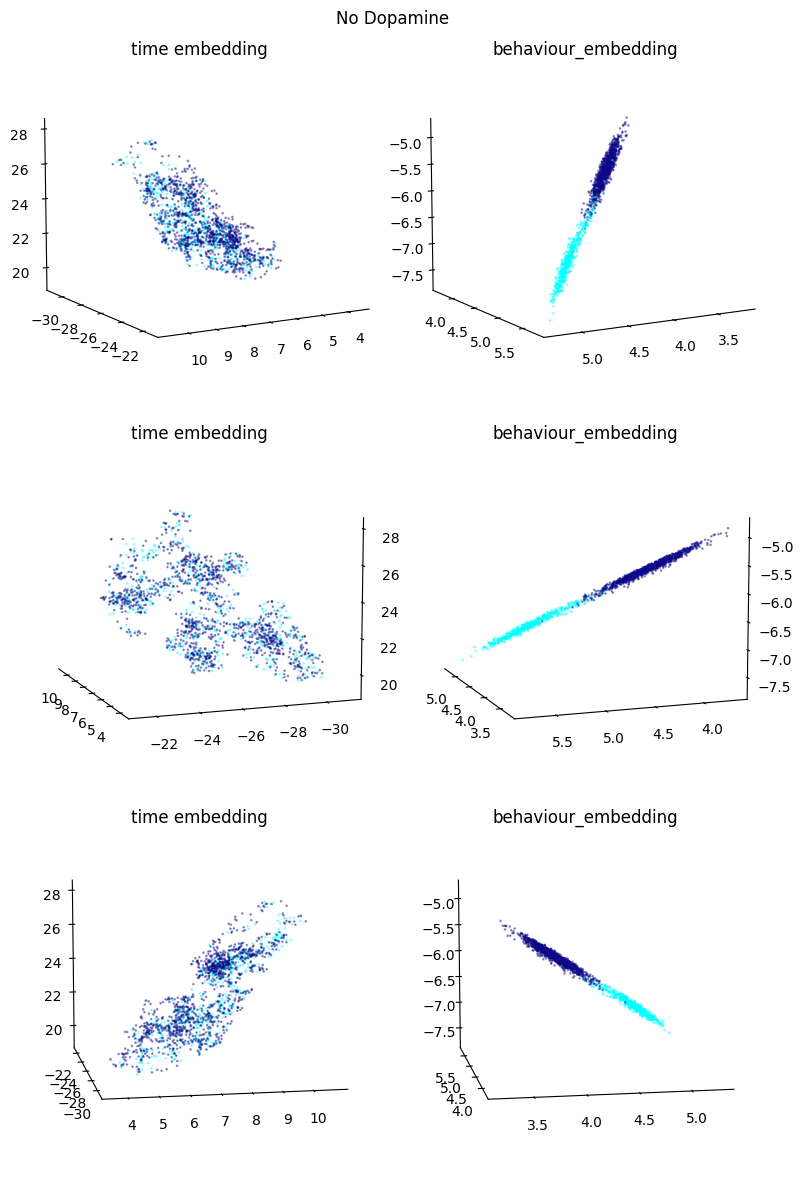

In [24]:
t_embed_nda, b_embed_nda = nm_analysis(datasets[0], "No Dopamine")

No NE

neural tensor shape:  torch.Size([1717, 60])
labels shape:  (1717,)


pos:  0.8992 neg:  3.1029 total:  4.0021 temperature:  1.0000: 100%|██████████| 2000/2000 [00:48<00:00, 41.33it/s]
pos:  0.3718 neg:  5.4873 total:  5.8592 temperature:  1.0000: 100%|██████████| 2000/2000 [00:49<00:00, 40.28it/s]


prepaing figure at multiple angles


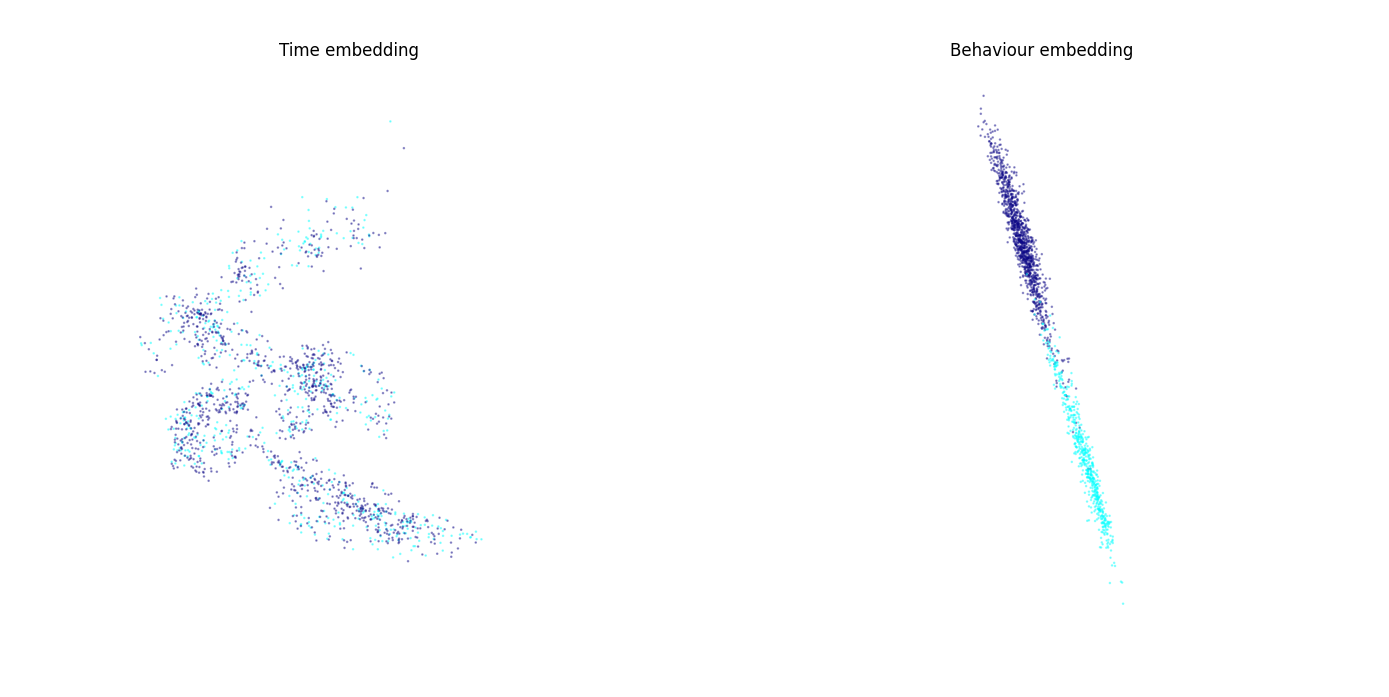

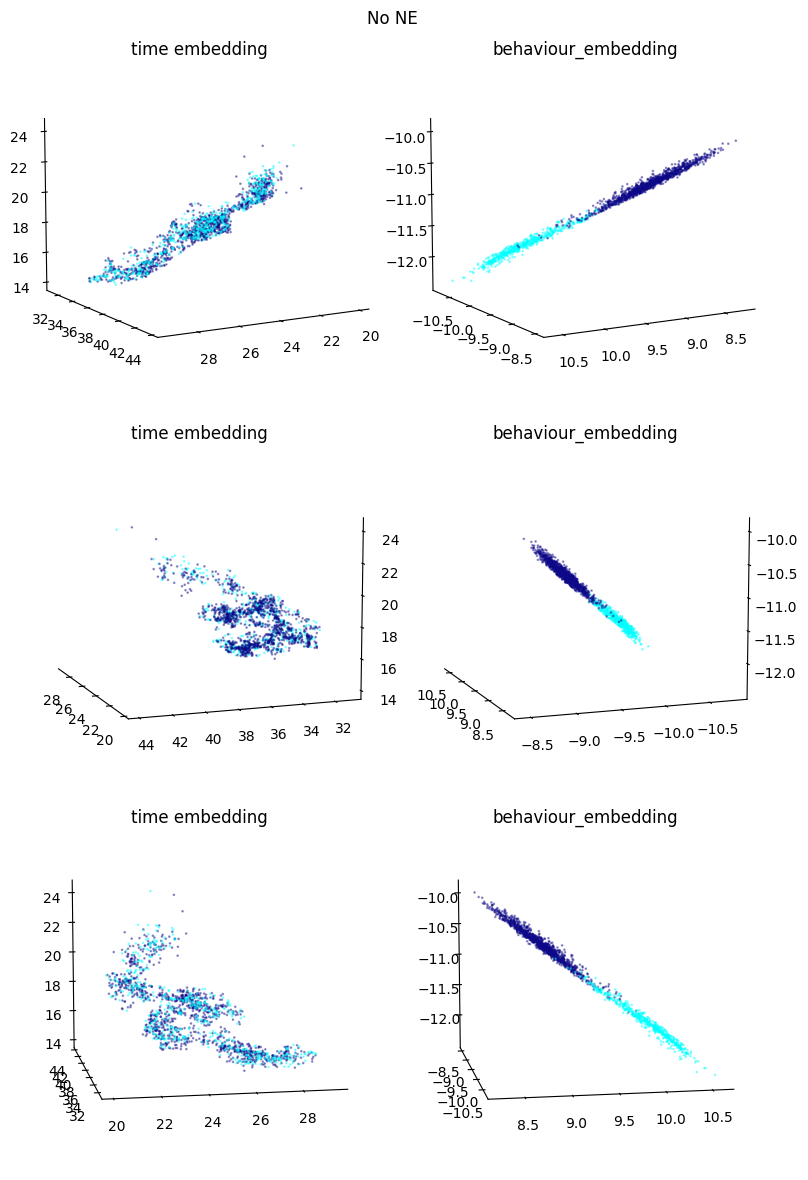

In [25]:
t_embed_nne, b_embed_nne = nm_analysis(datasets[1], "No NE")

No 5HT

neural tensor shape:  torch.Size([1717, 60])
labels shape:  (1717,)


pos:  0.8129 neg:  3.1402 total:  3.9532 temperature:  1.0000: 100%|██████████| 2000/2000 [00:48<00:00, 41.03it/s]
pos:  0.3131 neg:  5.4578 total:  5.7709 temperature:  1.0000: 100%|██████████| 2000/2000 [00:53<00:00, 37.57it/s]


prepaing figure at multiple angles


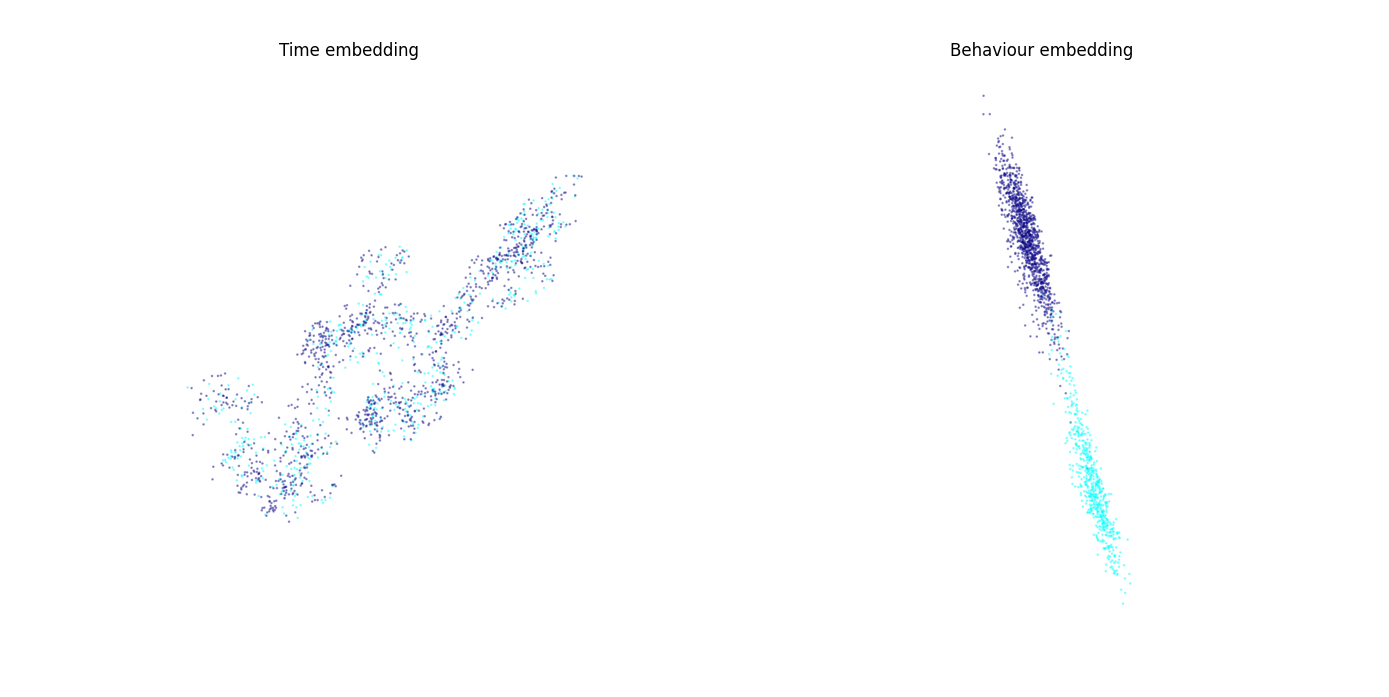

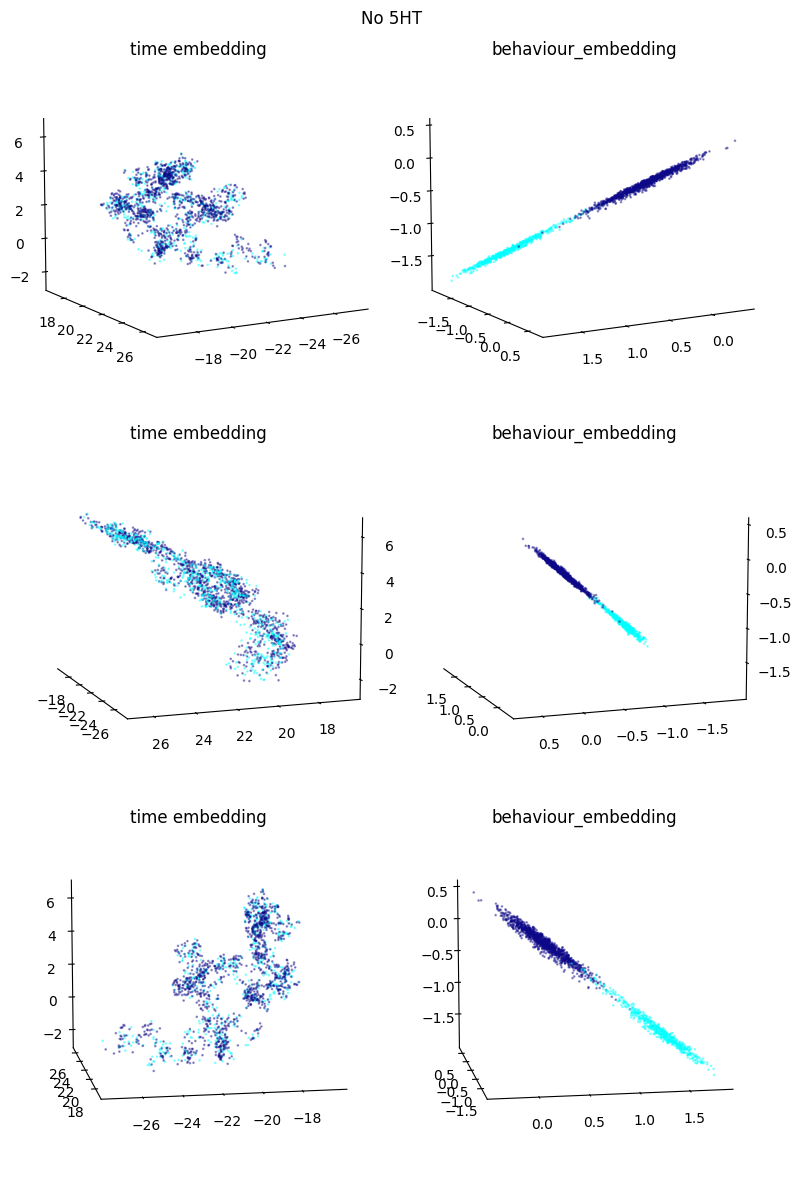

In [26]:
t_embed_nht, b_embed_nht = nm_analysis(datasets[2], "No 5HT")

No ACh

neural tensor shape:  torch.Size([1717, 60])
labels shape:  (1717,)


pos:  1.0142 neg:  3.0448 total:  4.0589 temperature:  1.0000: 100%|██████████| 2000/2000 [00:50<00:00, 39.85it/s]
pos:  0.2850 neg:  5.4612 total:  5.7462 temperature:  1.0000: 100%|██████████| 2000/2000 [00:53<00:00, 37.33it/s]


prepaing figure at multiple angles


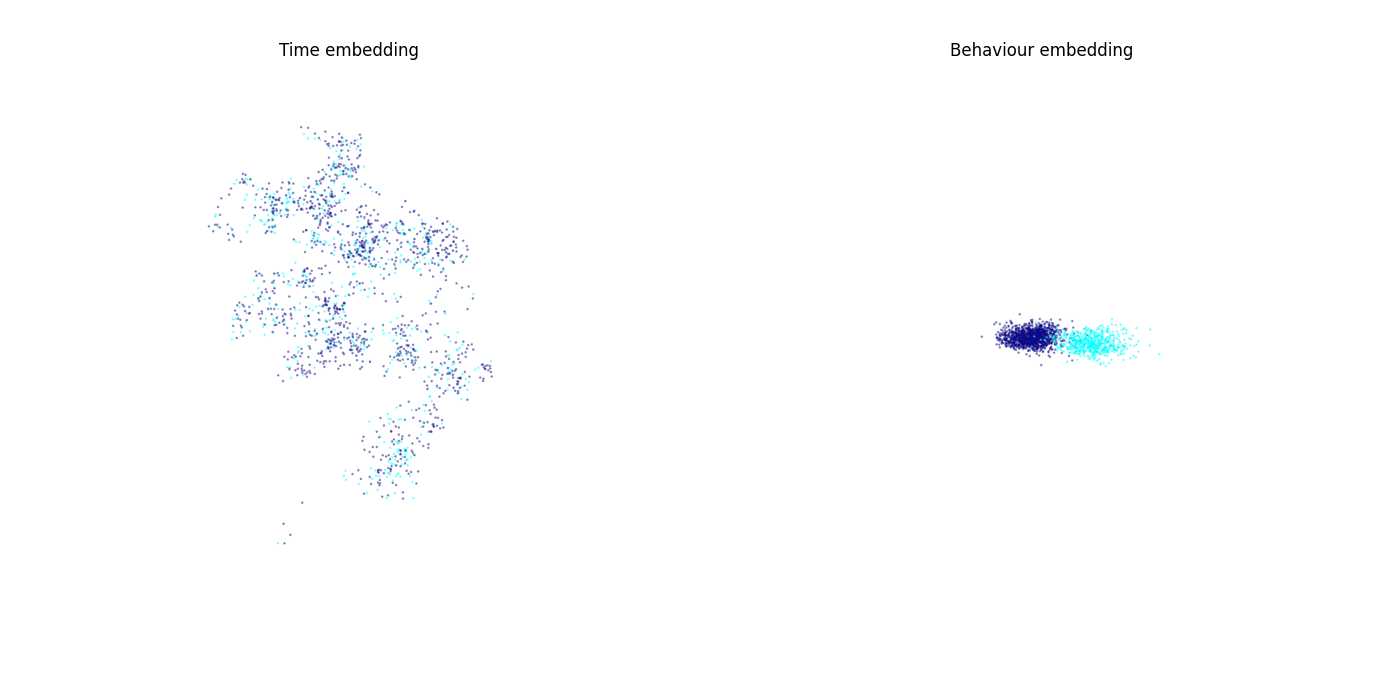

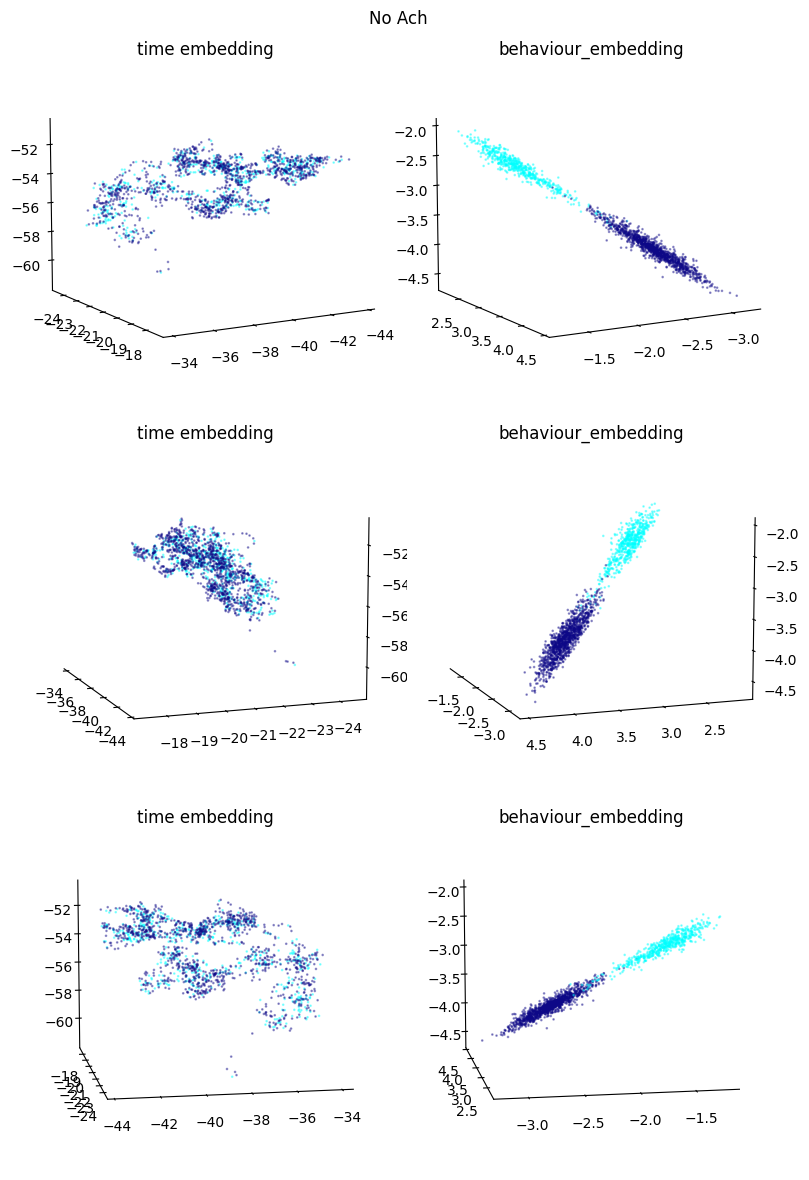

In [27]:
t_embed_nach, b_embed_nach = nm_analysis(datasets[3], "No Ach")

In [28]:
# make list of the embeddings produced
embeddings = [b_embed_nda, b_embed_nne, b_embed_nht, b_embed_nach]

In [29]:
n_plots = len(embeddings)

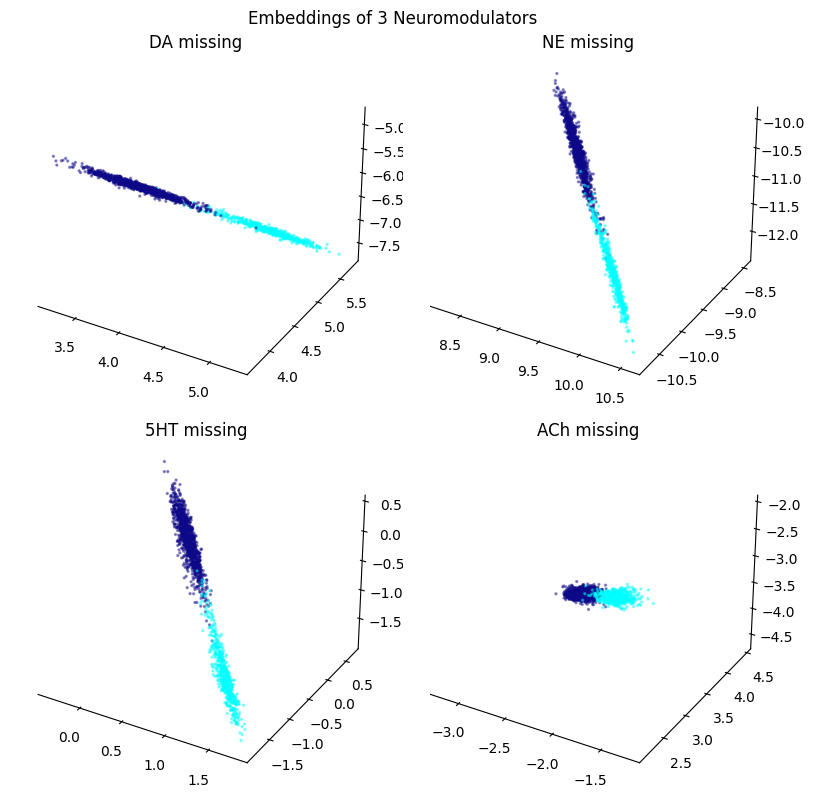

In [30]:
# plot the behaviour embeddings together for all combinations
fig = plt.figure(figsize=(8,4*n_plots))
gs = gridspec.GridSpec(n_plots, 2, figure=fig)

c = ['cool','plasma','pink','winter']
titles = ['DA missing', 'NE missing', '5HT missing', 'ACh missing']

for i, embed in enumerate(embeddings):

    # create the axes
    ax1 = fig.add_subplot(gs[i // 2, i%2], projection='3d')

    # plot the embedding
    cebra.plot_embedding(embedding=embed[rewarded,:], embedding_labels=trial_labels_[rewarded], ax=ax1, markersize=2,title=titles[i], cmap=c[0])
    cebra.plot_embedding(embedding=embed[unrewarded,:], embedding_labels=trial_labels_[unrewarded], ax=ax1, markersize=2,title=titles[i], cmap=c[1])

plt.suptitle("Embeddings of 3 Neuromodulators")
plt.tight_layout()


### Individual neuromodulators

Now let's study the NMs individually and see which ones encode reward.

In [65]:
def individual_datasets(traces_=traces):

    # create a list to hold the different NMs data
    datasets = []

    # loop through the traces
    for trace in traces_:

        # select the trace of the current NM
        array = np.array([traces_[trace]])

        # format the array 
        f_array = np.transpose(array)
        f_array = f_array.astype(np.float64)
        print("shape of formatted array:", f_array.shape)
        datasets.append(f_array)

    return datasets

In [66]:
individual_nms = individual_datasets()

shape of formatted array: (218572, 1)
shape of formatted array: (218572, 1)
shape of formatted array: (218572, 1)
shape of formatted array: (218572, 1)


In [27]:
4//2

2

In [67]:
# first make function to make the plots given a list of embeddings
def plot4_embeddings(embeddings, labels = trial_labels_, l_class=[rewarded, unrewarded], titles=['Dopamine (AUC:0.92)', 'Norepinephrine (AUC:0.96)', 'Serotonin (AUC:0.77)', 'Acetylcholine (AUC:0.85)']):

    # number of plots
    n_plots = len(embeddings)

    n_columns = 2
    n_rows = n_plots//n_columns

    # create axis
    fig = plt.figure(figsize=(8.5,4*n_columns))
    gs = gridspec.GridSpec(n_rows, n_columns, figure=fig)

    # colour 
    c = ['cool','plasma','pink','winter']

    for i, embed in enumerate(embeddings):

        # create the axes
        ax = fig.add_subplot(gs[i // n_columns, i%n_columns], projection='3d')

        ax.set_xlabel("latent 1", labelpad=0.001, fontsize=13)
        ax.set_ylabel("latent 2", labelpad=0.001, fontsize=13)
        ax.set_zlabel("latent 3", labelpad=0.001, fontsize=13)

        # Hide X and Y axes label marks
        ax.xaxis.set_tick_params(labelbottom=False)
        ax.yaxis.set_tick_params(labelleft=False)
        ax.zaxis.set_tick_params(labelright=False)

        # Hide X and Y axes tick marks
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_zticks([])

        # plot the embedding
        cebra.plot_embedding(embedding=embed[l_class[0],:], embedding_labels=labels[l_class[0]], ax=ax, markersize=2,title=titles[i], cmap=c[0])
        cebra.plot_embedding(embedding=embed[l_class[1],:], embedding_labels=labels[l_class[1]], ax=ax, markersize=2,title=titles[i], cmap=c[1])

    
    # Adjust the subplot layout manually
    #plt.subplots_adjust(left=0.1, right=0.55, top=0.95, bottom=0.05, wspace=0.0001)
    plt.suptitle("Embeddings of Single Neuromodulators", fontsize=15)
    plt.tight_layout()

In [29]:
# create function to run the analysis on the individual nm data 
def nm_analysis_2(data):

    # collect the behaviour embeddings in a list
    list_embeddings = []

    # run the nm analysis on the individual nms
    for i, dataset in enumerate(data):

        list_embeddings.append(nm_analysis(dataset)[1])

        print("COMPLETED ANALYSIS OF NM {}".format(i))

    # plot them
    plot4_embeddings(list_embeddings)

    return list_embeddings
    


neural tensor shape:  torch.Size([1717, 20])
labels shape:  (1717,)


pos: -0.6630 neg:  6.7379 total:  6.0749 temperature:  1.0000: 100%|██████████| 2000/2000 [00:41<00:00, 48.03it/s]
pos: -0.7383 neg:  6.7496 total:  6.0113 temperature:  1.0000: 100%|██████████| 2000/2000 [00:42<00:00, 47.18it/s]


COMPLETED ANALYSIS OF NM 0
neural tensor shape:  torch.Size([1717, 20])
labels shape:  (1717,)


pos: -0.6043 neg:  6.5337 total:  5.9294 temperature:  1.0000: 100%|██████████| 2000/2000 [00:38<00:00, 52.51it/s]
pos: -0.8557 neg:  6.7045 total:  5.8488 temperature:  1.0000: 100%|██████████| 2000/2000 [00:40<00:00, 49.54it/s]


COMPLETED ANALYSIS OF NM 1
neural tensor shape:  torch.Size([1717, 20])
labels shape:  (1717,)


pos: -0.7093 neg:  6.7817 total:  6.0724 temperature:  1.0000: 100%|██████████| 2000/2000 [00:41<00:00, 47.67it/s]
pos: -0.7203 neg:  6.8689 total:  6.1487 temperature:  1.0000: 100%|██████████| 2000/2000 [00:43<00:00, 46.50it/s]


COMPLETED ANALYSIS OF NM 2
neural tensor shape:  torch.Size([1717, 20])
labels shape:  (1717,)


pos: -0.7352 neg:  6.7342 total:  5.9990 temperature:  1.0000: 100%|██████████| 2000/2000 [00:44<00:00, 45.25it/s]
pos: -0.9999 neg:  7.2382 total:  6.2383 temperature:  1.0000: 100%|██████████| 2000/2000 [00:44<00:00, 45.39it/s]


COMPLETED ANALYSIS OF NM 3


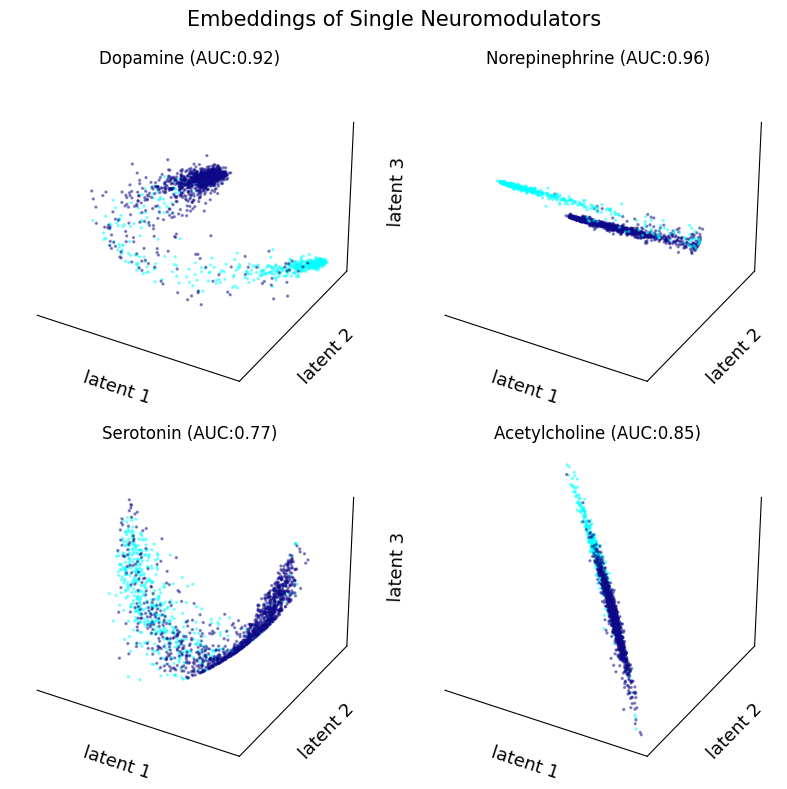

In [68]:
individual_embeddings = nm_analysis_2(individual_nms)

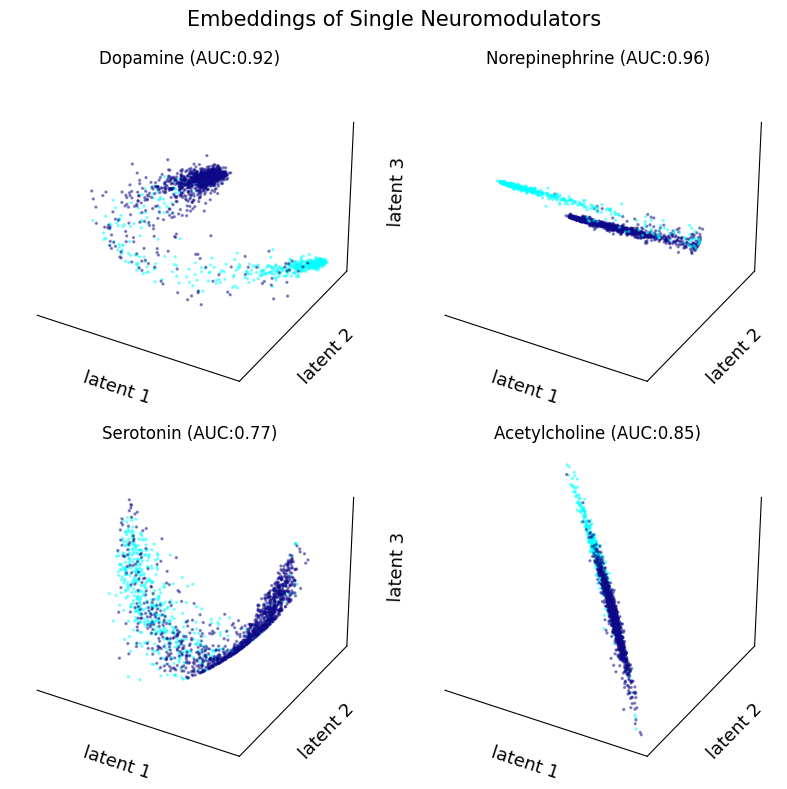

In [69]:
# remove labels
plot4_embeddings(individual_embeddings)


Ok, so it looks like DA, ACh and NE all encode the presence of reward in the trial. Now let's quantify how well each of the embeddings shows presence of reward. For this we'll use the AUC score.

## Quantify presence of reward in the embeddings

### Individual NMs

In [32]:
n_iterations = 5

In [33]:
for i, embeddding in enumerate(individual_embeddings):
    print(embeddding.shape)

(1717, 3)
(1717, 3)
(1717, 3)
(1717, 3)


In [70]:
trial_labels_.shape

(1717,)

In [77]:
# define function to get the auc scores
def get_auc(set_of_embeddings):   

     # list to store mean auc scores at each of these embedding dimensions
    mean_scores = []
    errors = []

    for j, embedding in enumerate(set_of_embeddings):

        # quantify with AUC score
        scores = []

        # for each NM make a couple of runs of the log regression model to get error bars
        for i in range(n_iterations):

            # make logistic function, fit it and use it to predict the initial labels from the embedding
            logreg = LogisticRegression(random_state=42)
            logreg.fit(embedding, trial_labels_)
            prediction = logreg.predict(embedding)

            # quantify how well the embedding mirrors the labels using the auc score

            # make a precision recall curve and get the threshold
            precision, recall, threshold = precision_recall_curve(trial_labels_, prediction)
            threshold = np.concatenate([np.array([0]), threshold])

            # calculate the fpr and tpr for all thresholds of the classification
            fpr, tpr, threshold = roc_curve(trial_labels_, prediction)

            # get the auc score and append it to the list
            roc_auc = auc(fpr, tpr)
            scores.append(roc_auc)

        # store the mean and the standard deviation 
        mean_scores.append(np.mean(scores))
        errors.append(np.std(scores))

    return mean_scores, errors, prediction


In [78]:
m_scores_snm, errors_snm, prediction = get_auc(individual_embeddings)

In [83]:
np.unique(trial_labels_, return_counts=True)

(array([0, 1]), array([1144,  573]))

In [82]:
np.unique(prediction, return_counts=True)

(array([0]), array([1717]))

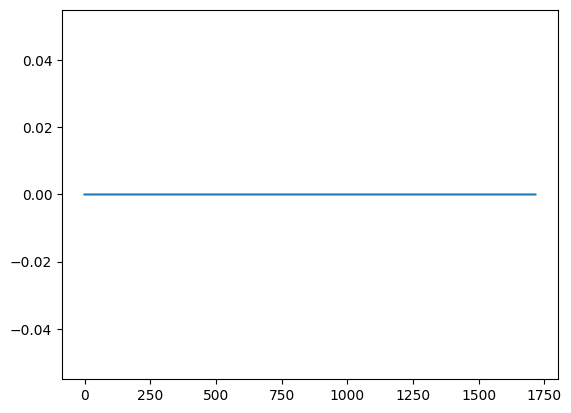

In [79]:
plt.plot(prediction)

In [73]:
list_nms = [trace for trace in traces.keys()]
list_nms

['DA NAc', 'NE NAc', '5HT NAc', 'ACh NAc']

In [74]:
np.round(m_scores_snm,2)

array([0.89, 0.96, 0.77, 0.5 ])

Text(0.5, 1.0, 'AUC score (logistic regression) for individual NM embeddings')

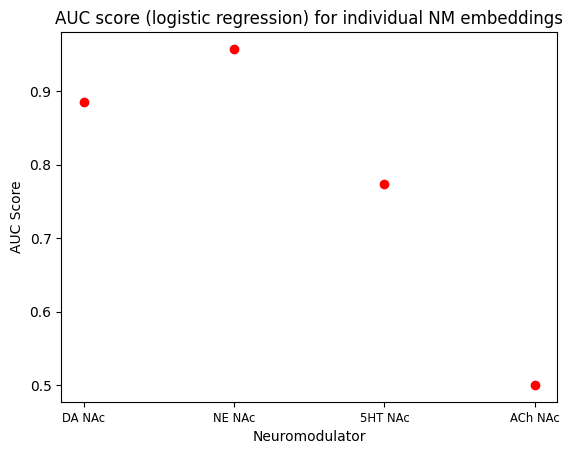

In [84]:
# print the auc score vs the embedding dimension
plt.errorbar(x=np.arange(0,4),y=m_scores_snm, yerr=errors_snm, fmt='ro')
plt.xlabel("Neuromodulator")
plt.xticks(range(len(list_nms)), list_nms, size='small')
plt.ylabel("AUC Score")
plt.title("AUC score (logistic regression) for individual NM embeddings")

### Combinations of 3 Embeddings

In [76]:
embeddings[0].shape

NameError: name 'embeddings' is not defined

In [ ]:
m_scores_3nm, errors_3nm = get_auc(embeddings)

In [ ]:
list_nnms = ['DA missing', 'NE missing', '5HT missing', 'ACh missing']

Text(0.5, 1.0, 'AUC score (logistic regression) for 3 NM embeddings')

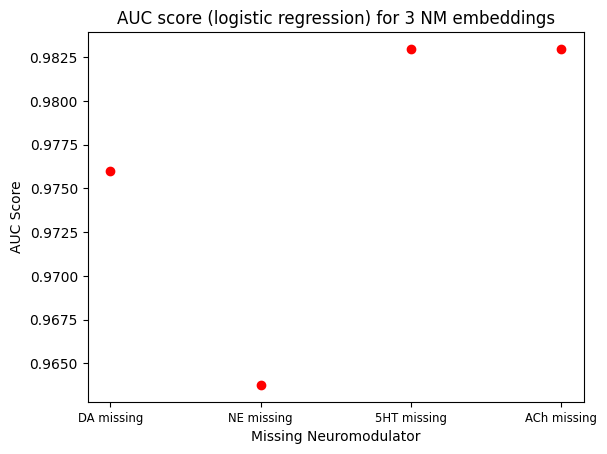

In [ ]:
# print the auc score vs the embedding dimension
plt.errorbar(x=np.arange(0,4),y=m_scores_3nm, yerr=errors_3nm, fmt='ro')
plt.xlabel("Missing Neuromodulator")
plt.xticks(range(len(list_nnms)), list_nnms, size='small')
plt.ylabel("AUC Score")
plt.title("AUC score (logistic regression) for 3 NM embeddings")

Later: test how well the CEBRA models are doing i.e. plot the loss and other model parameters